<h1><center>Physique numérique (PHY-3500)</center></h1>
<h1><center>TP1 - Intégration numérique</center></h1>

## Nom des membres de l'équipe:

### Légaré, Ophélie : 111 182 608
### Parrot, Anaïs : 111 184 980
### Turgeon, David : 111 182 265

### Importation des modules :

In [121]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.constants as cte
import scipy.stats as sta
from scipy.stats import moyal
from timeit import Timer,timeit
import scipy.integrate as sci
from scipy.integrate import quad

# Introduction : 

La radiothérapie externe est une méthode employée notamment dans le domaine de la radio-oncologie au CHUM pour le traitement du cancer. La radiothérapie externe traite les tumeurs au moyen de faisceaux de rayons-X, d'électrons ou de hadrons. La protonthérapie, quant à elle, est une branche spécifique de la radiothérapie visant à traiter les tumeurs peu profondes telles que les mélanomes oculaires à l'aide de faisceaux de protons de faible énergie. Cette technique permet d'optimiser la ballistique du faisceau afin de cibler la tumeur tout en épargnant les tissus sains.

Dans cette étude, on cherche à planifier et prédire la dose reçue par un patient suivant un traitement de protonthérapie. Pour ce faire, la portée des protons dans la matière est déterminée à l'aide de méthodes d'intégration numérique, soit la méthode des trapèzes et la méthode de Simpson. Par la suite, les algorithmes sont comparés à une distribution de Moyal. Le calcul de l'énergie déposée par le faisceau de protons à la tumeur est réalisé à partir de son énergie cinétique. Finalement, le réalisme du modèle d'intégration numérique développé est discuté.

# Équations utiles :

Pouvoir d'arrêt collisionnel massique :

\begin{align}
\frac{S_{col}}{\rho} = -\left(\frac{dT}{\rho dx}\right) = NZ\int^{T_e^{max}}_0 T \left(\frac{d\sigma}{dT'}\right)_{col}dT'
\end{align}

L'énergie maximale transférable à un électron par le proton :

\begin{align}
T_e^{max} = \frac{2m_ec^2(\gamma^2-1)}{1+2\gamma\frac{m_e}{m_p}+\left(\frac{m_e}{m_p}\right)^2}
\end{align}

Pouvoir d'arrêt collisionnel pour les protons :

\begin{align}
-\left(\frac{dT}{dx}\right)_{col} = 2\pi r_e^2 m_e c^2 n_e \frac{Z^2}{\beta^2}\left [\ln\left(\frac{2m_e c^2(\gamma^2-1)T_e^{max}}{I^2} \right)-\delta+\\
2(-\beta^2-\frac{C}{Z}+ZL_1+Z^2L_2)\right]
\end{align}

Pouvoir d'arrêt collisionnel pour protons de plus de 3 MeV (termes correctifs négligés) :

\begin{align}
S_{col}(T) = 2\pi r_e^2 m_e c^2 n_e \frac{1}{\beta^2} \left [\ln\left(\frac{2 m_e c^2 \beta^2 \gamma^2 T_e^{max}}{I^2}\right)-2\beta^2\right]
\end{align}

Portée des protons en ligne droite dans la matière :

\begin{align}
R_{CSDA} = \int^{T_i}_0 \frac{dT'}{\frac{S_{col}}{\rho}}
\end{align}

Énergie déposée pour un déplacement d'un proton s dans un milieu :

\begin{align}
s = \int^{T_i}_{T_f} \frac{dT'}{S_{col}}
\end{align}

Les différentes variables utilisées sont :

- r_e le rayon classique de l'électron
- n_e la densité électronique du matériaux
- Z la charge de la particule (Z = 1 pour les protons)
- N le nombre d'atome par gramme
- T' l'énergie transféré à l'électron de l'atome
- I l'énergie moyenne d'excitation du matériau,
- $\frac{d\sigma}{dT}$ section efficace différentielle pour les collision inélastique d'une énergie transféee T',
- $\beta$ et $\gamma$ sont les facteurs de Lorentz,
- $\delta$ un terme considérant les effets de la polarisation,
- $2\frac{C}{Z}$ corrige les effet du modèle en couche du cortège électronique atomique
- ZL$_1$ est la correction de Barkas
- Z$^2$L$_2$ est la correction de Bloch


## Question 1 :

La densité électronique d'un milieu peut être exprimée en fonction de sa composition atomique et de sa masse volumique à l'aide de l'équation suivante :

\begin{align}
n_e = \frac{N_A Z \rho}{A M_u} = 0.6022~x~10^{24}~ \frac{Z \rho}{A},
\end{align}

où $N_A$ est le nombre d'Avogadro, $Z$ est le numéro atomique, $\rho$ est la densité, $A$ est la masse atomique relative et $M_u$ est la  masse molaire. L'eau liquide et l'os compact (ICRU) sont des composés dont le numéro atomique et la masse atomique de chacun des éléments qui les composent sont pondérés selon leur fraction massique respective.

In [2]:
def densite_eau(rho,Z_1,A_1,Z_8,A_8):
    n_eau = (0.6022*10**(24))*rho*(0.111894*(Z_1/A_1)+0.888106*(Z_8/A_8))
    return n_eau
print(f"{densite_eau(1.00000,1,1.00794,8,15.9994):.16e} électrons par cm^3")

3.3427050859839407e+23 électrons par cm^3


In [3]:
def densite_os(rho,Z_1,A_1,Z_6,A_6,Z_7,A_7,Z_8,A_8,Z_12,A_12,Z_15,A_15,Z_16,A_16,Z_20,A_20):
    n_os = (0.6022*10**(24))*rho*(0.063984*(Z_1/A_1)+0.278000*(Z_6/A_6)+0.027000*(Z_7/A_7)+0.410016*(Z_8/A_8)+0.002000*(Z_12/A_12)+0.070000*(Z_15/A_15)+0.002000*(Z_16/A_16)+0.147000*(Z_20/A_20))
    return n_os
print(f"{densite_os(1.85000,1,1.00794,6,12.0107,7,14.0067,8,15.9994,12,24.3050,15,30.973762,16,32.065,20,40.078):.16e} électrons par cm^3")

5.9057675800925301e+23 électrons par cm^3


L'énergie moyenne d'excitation de l'eau liquide est de 75.000000 eV et celle de l'os compact (ICRU) est de 91.900000 eV. Les courbes des pouvoirs d'arrêt collisionnel de l'eau liquide et de l'os compact sont présentées ci-dessous avec une échelle logarithmique en abscisse. 

On veut maintenant calculer le pouvoir d'arrêt collisionnel grâce à l'équation 4 du TP. Pour ce faire, il faut commencer par calculer les facteurs de Lorentz $\beta$ et $\gamma$ et l'énergie maximale transferable à un  ́electron par le proton $T_e^{max}$.

In [4]:
mp = cte.m_p # Masse du proton
me = cte.m_e  # Masse de l'électron
c = cte.c # Vitesse de la lumière dans le vide
r_e = cte.physical_constants["classical electron radius"][0]  # Rayon classique de l'électron

def Lorentz_factor(T): # T pour énergie cinétique du proton (en J)        
    gamma = T/(mp * c**2) + 1
    beta = np.sqrt((gamma**2 - 1) / gamma**2)
    return gamma, beta

def T_e_max(gamma):  # en J
    numerateur = 2*me*c**2*(gamma**2-1)
    denominateur = 1+2*gamma*me/mp + (me/mp)**2
    return numerateur/denominateur

def pouvoir_arret(T, n_e, I, power = 1, rho = 1):  # T et I en eV, power servira à mettre l'équation à la puissance
    # -1 lors du calcul de la portée des protons dans la matière (voir la Question 5), rho servira à diviser le
    # pouvoir d'arrêt par la masse volumique lorsqu'il est souhaité (comme à la Question 5)
    
    # Pour les protons de plus de 3 MeV !
    T *= cte.e # Transformation de l'énergie en eV vers des J
    I *= cte.e # Transformation de l'énergie d'excitation en eV vers des J
    gamma, beta = Lorentz_factor(T)
    Temax = T_e_max(gamma)
    
    arg_log = 2*me*c**2*beta**2*gamma**2*Temax/I**2
    S_col = 2*np.pi * (r_e*100)**2 * me*c**2 * n_e/beta**2 * (np.log(arg_log) - 2*beta**2)  # r_e mis en cm pour 
    # compenser n_e en cm^-3
    return (S_col/cte.e /rho)**power  # Pour avoir S_col en eV/cm

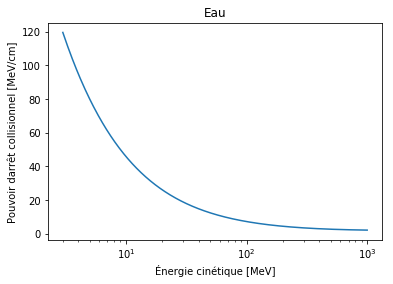

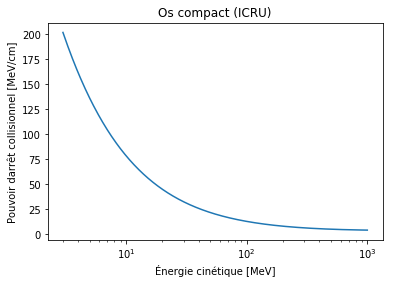

In [5]:
T = np.linspace(3, 1000, 10000)  # en MeV
ne_eau = densite_eau(1.00000,1,1.00794,8,15.9994)
ne_os = densite_os(1.85000,1,1.00794,6,12.0107,7,14.0067,8,15.9994,12,24.3050,15,30.973762,16,32.065,20,40.078)

plt.plot(T, pouvoir_arret(T*1e6, ne_eau, 75)/1e6)
plt.title("Eau")
plt.xlabel("Énergie cinétique [MeV]")
plt.ylabel('Pouvoir d''arrêt collisionnel [MeV/cm]')
plt.xscale('log')
plt.show()

plt.plot(T, pouvoir_arret(T*1e6, ne_os, 91.9)/1e6)
plt.title("Os compact (ICRU)")
plt.xlabel("Énergie cinétique [MeV]")
plt.ylabel('Pouvoir d''arrêt collisionnel [MeV/cm]')
plt.xscale('log')
plt.show()

# Portée des protons dans la matière

## Question 2 :
La portée des protons en ligne droite dans la matière est approximée par une décélération continue (CSDA) et est donnée par l'équation suivante :
\begin{align}
R_{CSDA} = \int^{T_i}_0 \frac{dT'}{\frac{S_{col}}{\rho}},
\end{align}
soit l'intégrale de l'inverse du pouvoir d'arrêt collisionnel massique par rapport à l'énergie transférée à l'électron de l'atome.
L'homogénéité dimensionnelle de la portée des protons en ligne droite est déterminée en vérifiant les unités de part et d'autre de l'égalité. Selon l'outil PSTAR du NIST, les unités sont des g/cm^2. On développe le côté droit de l'égalité afin de vérifier l'homogénéité dimensionnelle pour des protons de plus de 3 MeV.
\begin{align}
R_{CSDA} = \int^{T_i}_0 \frac{dT'}{\frac{S_{col}}{\rho}} = \int^{T_i}_0 \frac{\rho dT'}{2\pi r_e^2 m_e c^2 n_e \frac{1}{\beta^2} \left [\ln\left(\frac{2 m_e c^2 \beta^2 \gamma^2 T_e^{max}}{I^2}\right)-2\beta^2\right]} = \int^{T_i}_0 \frac{dT'}{-\left(\frac{dT}{\rho dx}\right)_{col}}.
\end{align}
Les unités sont donc ;
\begin{align}
\left[\frac{g}{cm^2}\right] = \int^{T_i}_0 dT'\frac{\left[\frac{g}{cm^3}\right]}{\left[\frac{MeV}{cm}\right]} = \int^{T_i}_0 dT'\left[\frac{g}{MeV cm^2}\right].
\end{align}
En intégrant cette fonction par rapport à l'énergie, on obtient les mêmes unités de part et d'autre de l'égalité ;
\begin{align}
\left[\frac{g}{cm^2}\right] = \left[\frac{g}{cm^2}\right],
\end{align}
donc l'homogénéité dimensionnelle de la portée des protons en ligne droite est démontrée.

## Question 3 :
Le pouvoir d'arrêt collisionnel total pour une particule donnée est composé de l'arrêt collisionnel électronique (ionisation des atomes) et de l'arrêt collisionnel nucléaire (diffusion sur des noyaux). Il est également possible que cette particule donnée subisse des pertes radiatives (Bremsstrahlung, production de paires ou intéraction photoélectrique) durant sa trajectoire dans la matière. 

Pour les protons dans la gamme des énergies de la protonthérapie, le pouvoir d'arrêt collisionnel total peut être approximé par le pouvoir d'arrêt collisionnel électronique puisque tous deux sont du même ordre de grandeur peu importe l'énergie du proton. En effet, si on base notre analyse sur les résultats de l'outil PSTAR du NIST pour l'eau liquide, on remarque que ces deux derniers présentent un écart d'au plus 0.08%, tandis que l'arrêt collisionnel nucléaire est inférieur par un facteur d'environ $10^{3}$ pour les énergies de la protonthérapie puis ce cet écart s'accroît rapidement jusqu'à $10^{5}$ pour des énergies supérieures. Le pouvoir d'arrêt collisionnel nucléaire peut donc être négligé. On note que des résultats du même ordre de grandeur sont obtenus pour l'os compact (ICRU) à l'aide de cet outil, ce qui confirme que cette approximation est valide aussi dans ce milieu.

Quant aux pertes radiatives, elles sont davantage présentes dans le comportement des particules légères telles que les électrons et les positrons qui subissent des pertes non négligeables mêmes pour des faibles énergies de l'ordre de $10^{-2}$ MeV. Dans le cas des protons, les pertes radiatives sont présentes pour des énergies de l'ordre de $10^{3}$ MeV et prennent plus d'importance pour des énergies encore plus élevées qui ne font pas partie de la gamme des énergies utilisée protonthérapie. C'est la masse élevée des protons qui réduit l'effet des pertes radiatives en protonthérapie.

## Question 4 :
Il est nécessaire d'employer une méthode numérique pour calculer la portée des protons car il n'est pas possible de calculer cette dernière de façon analytique. On a donc recours à l'intégration numérique par la méthode des trapèzes et par la méthode de Simpson. Tel que présenté à la question 1, le pouvoir d'arrêt collisionnel varie en fonction de l'énergie des protons et du milieu traversé par le faisceau de protons. La portée des protons dépend entre autres des énergies de faisceau sélectionnées, de la forme et de la profondeur de la tumeur à traiter, de l'anatomie ainsi que de la morphologie spécifique du patient. Il s'agit de calculs complexes et laborieux qui nécessitent une exactitude au millimètre ou dixième de millimètre près afin de préserver les tissus sains. La calul numérique de la portée des protons permet d'économiser du temps lors de la préparation du traitement de chaque patient et de s'assurer que la ballistique du traitement est exacte et optimale.

## Question 5 :

Comme mentionné en introduction, deux méthodes d'intrégration seront utilisés ici : la méthode des trapèzes et la méthode de Simpson. Leur algorithme respectif est écrit ci-dessous.

In [21]:
def methode_trapezes(fonction, a, b, N, *args):  
    # fonction = celle à intégrer, a = 1ère borne d'intégration, b = 2e borne d'intégration, N = nombre de tranches
    if N == 0:   # Pour éviter une division par zéro (au calcul de h)
        return 0

    x = np.linspace(a, b, N+1) 
    h = (b - a) / N  # épaisseur de chaque tranche
    somme = 0
    for i in x[1:-1]:
        somme += fonction(i, *args)
    return h * (1/2*fonction(x[0], *args) + 1/2*fonction(x[-1], *args) + somme)

def methode_Simpson(fonction, a, b, N, *args):
    # fonction = celle à intégrer, a = 1ère borne d'intégration, b = 2e borne d'intégration, N = nombre de tranches
    if N == 0:   # Pour éviter une division par zéro (au calcul de h)
        return 0
    
    x = np.linspace(a, b, N+1)
    h = (b - a) / N  # épaisseur de chaque tranche
    somme_impaire = 0
    somme_paire = 0
    for i in x[1:-1:2]:
        somme_impaire += fonction(i, *args)
    for i in x[2:-2:2]:
        somme_paire += fonction(i, *args)
    
    return 1 / 3 * h * (fonction(x[0], *args) + fonction(x[-1], *args) + 4 * somme_impaire + 2 * somme_paire)

In [82]:
def calcul_erreur(precision,methode, fonction, a, b, N, *args):
    I_prec = 0
    erreur = 1
    erreur_prec = 1
    if str(methode.__name__) == "methode_trapezes":
        while abs(erreur) > I_prec*precision:
            if I_prec == 0:
                I_prec = methode(fonction, a, b, N, *args)
                N_tranches = [N]
                portee_protons = [I_prec]
                N_i = N * 2
            else:
                erreur_prec = erreur
                h_i = (b - a) / N_i
                somme = 0
                for k in range(1, N_i, 2):
                    somme += fonction(a+k*h_i, *args)

                I_i = 1/2 * I_prec + h_i * somme
                erreur = 1/3 * (I_i - I_prec)
                N_tranches.append(N_i)
                portee_protons.append(I_i)
                print(erreur, N_i)
                I_prec = I_i
                N_i *= 2
                if abs(erreur_prec) < abs(erreur):
                    break
        return N_tranches, portee_protons
    
    elif str(methode.__name__) == "methode_Simpson":
        while abs(erreur) > I_prec*precision:
            if I_prec == 0:
                I_prec = methode(fonction, a, b, N, *args)

                N_tranches = [N]
                portee_protons = [I_prec]
                
                h_i = (b - a) / N  # épaisseur de chaque tranche
                somme_impaire = 0
                somme_paire = 0
                for k in range(2,N-2):
                    somme_paire += fonction(a+k*h_i, *args)
                S_i_prec = 1/3 * (fonction(a,*args)+fonction(b, *args)+2*somme_paire)
                
                for k in range(1,N-1,2):
                    somme_impaire += fonction(a+k*h_i, *args)
                T_i_prec = 2/3*somme_impaire
                
                N_i = N * 2
            else:
                
                h_i = (b - a) / N_i  # épaisseur de chaque tranche
                somme_impaire = 0
                S_i = S_i_prec + T_i_prec
                for k in range(1,N_i-1,2):
                    somme_impaire += fonction(a+k*h_i, *args)
                T_i = 2/3*somme_impaire
                I_i = h_i * (S_i + 2 * T_i)
                
                N_tranches.append(N_i)
                portee_protons.append(I_i)
                
                erreur = 1/15 * (I_i - I_prec)
                print(erreur, N_i)
                I_prec = I_i
                S_i_prec = S_i
                T_i_prec = T_i
                
                N_i *= 2
        return N_tranches, portee_protons
    else:
        raise ValueError("La méthode doit être 'methode_trapeze' ou bien 'methode_Simpson'")


In [103]:
portee_eau_trapezes = calcul_erreur(1.49e-8 ,methode_trapezes, pouvoir_arret, 3e6, 150e6, 100, ne_eau, 75, -1, 1)

5.640115195918819e-05 200
1.4116835166314937e-05 400
3.5302800848550455e-06 800
8.826376204732848e-07 1600
2.2066364143332368e-07 3200


In [9]:
#plt.figure()
#plt.plot(portee_eau_trapezes[0], portee_eau_trapezes[1])
#plt.title("Eau")
#plt.xlabel("Nombre de tranches")
#plt.ylabel("Portée des protons [g/cm$^2$]")
#plt.show()

In [10]:
def précision_machine(methode,a,b,*args): # Déterminer le nombre de tranches pour atteindre la précision machine
    valeur = 0
    nouvelle_valeur = 0
    i = 1000
    it = 0
    while True:
        nouvelle_valeur = methode(pouvoir_arret,a,b,i,*args)
        if i == 1000:
            valeur = nouvelle_valeur
        else: # déterminer si la nouvelle valeur est à ± 1e-16 la valeur précédente
            if (nouvelle_valeur < valeur+1e-16) and (nouvelle_valeur > valeur-1e-16):
                break
            else:
                valeur = nouvelle_valeur
                
        if i > 10000000: # Éviter les itérations infini dans le cas de "bug"
            break
        i *= 2 # On double le nombre de tranche à chaque itération
        it += 1
        print(i,valeur)
    return i,it, valeur

#print(précision_machine(methode_trapezes,3e6, 150e6,1, ne_eau, 75,-1)) # Servent à déterminer le nombre de tranche pour la précision machine
#print(précision_machine(methode_Simpson,3e6, 150e6,1, ne_eau, 75,-1))
#print(précision_machine(methode_trapezes,3e6, 150e6,1.85, ne_os, 91.9,-1))
#print(précision_machine(methode_Simpson,3e6, 150e6,1.85, ne_os, 91.9,-1))

#print(f"Le nombre de tranches nécessaire pour atteindre la précision machine pour la méthode trapèze de la portée dans l'eau est de:\n{précision_machine(methode_trapezes,3e6, 150e6,1, ne_eau, 75,-1)[0]}.")
#print(f"Le nombre de tranches nécessaire pour atteindre la précision machine pour la méthode Simpson de la portée dans l'eau est de:\n{précision_machine(methode_Simpson,3e6, 150e6,1, ne_eau, 75,-1)[0]}.")
#print("Les mêmes valeurs sont trouvé pour la portée dans l'os.")

In [51]:
def trouver_N_trapeze_pour_precision(a,b,n,precision,fonction,*args):
    error = 1
    N = 1
    trapz = methode_trapezes(fonction,a, b, 100000, *args)
    h = (b - a) / N

    v_a0 = fonction(a,*args)
    v_a1 = fonction(a+n,*args)
    v_a2 = fonction(a-n,*args)

    p_a1 = (v_a0-v_a1)/(n)
    p_a2 = (v_a0-v_a2)/(-n)
    da = (p_a1+p_a2)/2 # dérivée autour de a

    v_b0 = fonction(b,*args)
    v_b1 = fonction(b+n,*args)
    v_b2 = fonction(b-n,*args)

    p_b1 = (v_b0-v_b1)/(n)
    p_b2 = (v_b0-v_b2)/(-n)
    db = (p_b1+p_b2)/2 # dérivée autour de b

    N = (b-a)*np.sqrt(abs(da-db)/(12*trapz*precision))
    return N

print(trouver_N_trapeze_pour_precision(3e6,150e6,1e-6,1.49e-8,pouvoir_arret, ne_eau, 75,-1,1))


pouvoir_arret
15.753314669188496
3249.559084990723


In [12]:
"""Simpson_eau = [methode_Simpson(pouvoir_arret, 3e6, 150e6, 2**i, ne_eau, 75,-1)*1 for i in range(int(précision_machine(methode_Simpson,3e6, 150e6,1, ne_eau, 75,-1)[1]))]
Simpson_os = [methode_Simpson(pouvoir_arret, 3e6, 150e6, 2**i, ne_os, 91.9,-1)*1.85 for i in range(int(précision_machine(methode_Simpson,3e6, 150e6,1.85, ne_os, 91.9,-1)[1]))]
trapeze_eau = [methode_trapezes(pouvoir_arret, 3e6, 150e6, 2**i, ne_eau, 75,-1)*1 for i in range(int(précision_machine(methode_trapezes,3e6, 150e6,1, ne_eau, 75,-1)[1]))]
trapeze_os = [methode_trapezes(pouvoir_arret, 3e6, 150e6, 2**i, ne_os, 91.9,-1)*1.85 for i in range(int(précision_machine(methode_trapezes,3e6, 150e6,1.85, ne_os, 75,-1)[1]))]
plt.rcParams["figure.figsize"]=20,10
plt.rcParams.update({'font.size': 15})
#print(trapeze_eau)

plt.subplot(421)
plt.plot([2**i for i in range(précision_machine(methode_trapezes,3e6, 150e6,1, ne_eau, 75,-1)[1])],trapeze_eau)
plt.xscale("log")
plt.xlabel("Nombre de tranche [-]")
plt.ylabel("Portée obtenue [$\\frac{g}{cm^2}$]")
plt.title("Eau trapèze")

plt.subplot(423)
plt.plot([2**i for i in range(précision_machine(methode_Simpson,3e6, 150e6,1, ne_eau, 75,-1)[1])],Simpson_eau)
plt.xscale("log")
plt.xlabel("Nombre de tranche [-]")
plt.ylabel("Portée obtenue [$\\frac{g}{cm^2}$]")
plt.title("Eau Simpson")

plt.subplot(422)
plt.plot([2**i for i in range(précision_machine(methode_trapezes,3e6, 150e6,1.85, ne_os, 91.9,-1)[1])],trapeze_os)
plt.xscale("log")
plt.xlabel("Nombre de tranche [-]")
plt.ylabel("Portée obtenue [$\\frac{g}{cm^2}$]")
plt.title("Os trapèze")

plt.subplot(424)
plt.plot([2**i for i in range(précision_machine(methode_Simpson,3e6, 150e6,1.85, ne_os, 91.9,-1)[1])],Simpson_os)
plt.xscale("log")
plt.xlabel("Nombre de tranche [-]")
plt.ylabel("Portée obtenue [$\\frac{g}{cm^2}$]")
plt.title("Os Simpson")
plt.tight_layout()
plt.show()"""


'Simpson_eau = [methode_Simpson(pouvoir_arret, 3e6, 150e6, 2**i, ne_eau, 75,-1)*1 for i in range(int(précision_machine(methode_Simpson,3e6, 150e6,1, ne_eau, 75,-1)[1]))]\nSimpson_os = [methode_Simpson(pouvoir_arret, 3e6, 150e6, 2**i, ne_os, 91.9,-1)*1.85 for i in range(int(précision_machine(methode_Simpson,3e6, 150e6,1.85, ne_os, 91.9,-1)[1]))]\ntrapeze_eau = [methode_trapezes(pouvoir_arret, 3e6, 150e6, 2**i, ne_eau, 75,-1)*1 for i in range(int(précision_machine(methode_trapezes,3e6, 150e6,1, ne_eau, 75,-1)[1]))]\ntrapeze_os = [methode_trapezes(pouvoir_arret, 3e6, 150e6, 2**i, ne_os, 91.9,-1)*1.85 for i in range(int(précision_machine(methode_trapezes,3e6, 150e6,1.85, ne_os, 75,-1)[1]))]\nplt.rcParams["figure.figsize"]=20,10\nplt.rcParams.update({\'font.size\': 15})\n#print(trapeze_eau)\n\nplt.subplot(421)\nplt.plot([2**i for i in range(précision_machine(methode_trapezes,3e6, 150e6,1, ne_eau, 75,-1)[1])],trapeze_eau)\nplt.xscale("log")\nplt.xlabel("Nombre de tranche [-]")\nplt.ylabel("P

## Question 6 :

On obtient l'expression analytique de la dérivée du pouvoir d'arrêt collisionnel en fonction de T en l'exprimant en fonction de $\gamma$ et en utilisant le théorème de dérivation des fonctions composées. Le pouvoir d'arrêt collisionnel en fonction de T pour des protons de plus de 3 MeV est donné par

\begin{align}
S_{col}(T) = 2\pi r_e^2 m_e c^2 n_e \frac{1}{\beta^2} \left [\ln\left(\frac{2 m_e c^2 \beta^2 \gamma^2 T_e^{max}}{I^2}\right)-2\beta^2\right].
\end{align}

Avec les simplifications et substitutions suggérées dans l'énoncé, on obtient les équations suivantes.

\begin{align}
S_{col}(T) = U \frac{1}{\beta^2} \left [\ln\left(\frac{a (\gamma^2-1)}{I^2} \frac {a (\gamma^2-1)}{\gamma \delta + b}\right)-2\beta^2\right]
\end{align}

\begin{align}
S_{col}(T) = U \frac{1}{\beta^2} \left [\ln\left(\frac{k (\gamma^2-1)^2}{\gamma \delta + b}\right)-2\beta^2\right]
\end{align}

\begin{align}
S_{col}(T) = \frac{U \gamma^2}{(\gamma^2-1)} \left [\ln\left(\frac{k (\gamma^2-1)^2}{\gamma \delta + b}\right)-2\frac{(\gamma^2-1)}{\gamma^2}\right]
\end{align}

\begin{align}
S_{col}(T) = \frac{U \gamma^2}{(\gamma^2-1)} \ln\left(\frac{k (\gamma^2-1)^2}{\gamma \delta + b}\right)-2U
\end{align}

Sachant que $\gamma$ peut s'exprimer en fonction de $T$ comme suit

\begin{align}
\gamma = \frac{T}{m_pc^2}+1,
\end{align}

on peut se servir du théorème de dérivation des fonctions composées pour obtenir la dérivée du pouvoir d'arrêt collisionnel en fonction de T de la manière suivante.

\begin{align}
\frac{dS_{col}}{dT} = \frac{dS_{col}}{d\gamma}\frac{d\gamma}{dT} 
\end{align}

La première dérivée est 

\begin{align}
\frac{dS_{col}}{d\gamma} = U \frac{d}{d\gamma} \left[\frac{\gamma^2}{(\gamma^2-1)} ln\left(\frac{k (\gamma^2-1)^2}{\gamma \delta + b}\right) \right]
\end{align}

\begin{align}
\frac{dS_{col}}{d\gamma} = U \Bigg(\left[\frac{\gamma(\gamma^2-1)-\gamma^2(2\gamma)}{(\gamma^2-1)^2} ln\left(\frac{k (\gamma^2-1)^2}{\gamma \delta + b}\right) \right] + \left[\frac{\gamma^2}{(\gamma^2-1)}\frac{\gamma \delta + b}{k (\gamma^2-1)^2}\frac{4k\gamma\left(\gamma^2-1\right)\left(\gamma \delta + b \right) - k\delta\left(\gamma^2-1\right)^2}{(\gamma \delta + b)^2} \right]\Bigg)
\end{align}

\begin{align}
\frac{dS_{col}}{d\gamma} = U \Bigg(\left[\frac{\gamma(\gamma^2-1)-2\gamma^3}{(\gamma^2-1)^2} ln\left(\frac{k (\gamma^2-1)^2}{\gamma \delta + b}\right) \right] + \left[\frac{\gamma^2(\gamma \delta + b)}{k(\gamma^2-1)^3}\frac{4k\gamma(\gamma^2-1)(\gamma \delta + b) - k\delta(\gamma^2-1)^2}{(\gamma \delta + b)^2} \right]\Bigg).
\end{align}

La deuxième dérivée est simplement 

\begin{align}
\frac{d\gamma}{dT} = \frac{1}{m_pc^2}.
\end{align}

Donc selon le théorème de dérivation des fonctions composées, on obtient

\begin{align}
\frac{dS_{col}}{dT} = \frac{U}{m_pc^2} \Bigg(\left[\frac{\gamma(\gamma^2-1)-2\gamma^3}{(\gamma^2-1)^2} ln\left(\frac{k (\gamma^2-1)^2}{\gamma \delta + b}\right) \right] + \left[\frac{\gamma^2(\gamma \delta + b)}{k(\gamma^2-1)^3}\frac{4k\gamma(\gamma^2-1)(\gamma \delta + b) - k\delta(\gamma^2-1)^2}{(\gamma \delta + b)^2} \right]\Bigg).
\end{align}

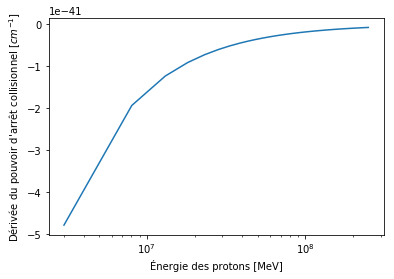

In [37]:
U = 2 * np.pi * r_e**2 * me *c**2
a = 2*me*c**2
b = 1+(me/mp)**2
k = (a/(0.000075))**2 # I = 75.000 eV pour l'eau
delta = 2*me/mp

T = np.linspace(3, 250)  # en MeV
data = []
for i in T:
    gamma = i/(mp * c**2) + 1
    dS_col = U/(mp*c**2)*((((gamma*(gamma**2 -1)-2*gamma**3)/(gamma**2-1)**2)*np.log(k*(gamma**2-1)**2/(gamma*delta+b)))+((gamma**2*(gamma*delta+b)*(4*k*gamma*(gamma**2-1)*(gamma*delta+b)-k*delta*(gamma**2-1)**2))/(k*(gamma**2-1)**3*(gamma*delta+b)**2)))
    data.append(dS_col)

plt.plot(T*1e6,data)
plt.xscale("log")
plt.xlabel("Énergie des protons [MeV]")
plt.ylabel("Dérivée du pouvoir d'arrêt collisionnel [$cm^{-1}$]")
plt.show()

## Question 7 :

In [67]:
def erreur_approx_trapeze(fonction, a, b,N,n, *args): # n est la distance des points utilisé pour faire la dérivée
    
    h = (b - a) / N

    v_a0 = fonction(a,*args)
    v_a1 = fonction(a+n,*args)
    v_a2 = fonction(a-n,*args)
    
    p_a1 = (v_a0-v_a1)/(n)
    p_a2 = (v_a0-v_a2)/(-n)
    da = (p_a1+p_a2)/2 # dérivée autour de a
    
    v_b0 = fonction(b,*args)
    v_b1 = fonction(b+n,*args)
    v_b2 = fonction(b-n,*args)
    
    p_b1 = (v_b0-v_b1)/(n)
    p_b2 = (v_b0-v_b2)/(-n)
    db = (p_b1+p_b2)/2 # dérivée autour de b
    print(p_a1,p_a2)
    return 1/12*h**2*(da-db)
print(erreur_approx_trapeze(pouvoir_arret, 3e6, 150e6, 3200,1e-6, ne_eau, 75,-1))
print(pouvoir_arret(3e6,ne_eau,75,-1))

-2.236696376343387e-15 -2.236696376343387e-15
-2.420511418089155e-07
8.367659897026891e-09


# Optimisation

## Question 8 :
La distribution en énergie des protons peut être approximée par une distribution de Moyal telle que présentée par la figure suivante pour la gamme d'énergies de la protonthérapie.

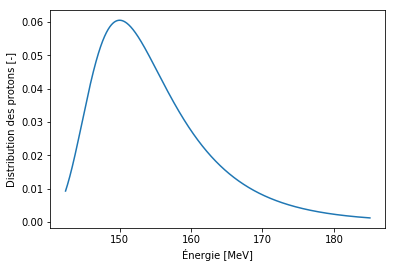

[147.50241902 152.48484644 148.72659924 155.46727068 144.51799348
 150.82218808 195.40930988 158.62209731 154.08411463 157.30818049
 145.34914372 146.63699663 150.5091111  154.52284538 151.91631131
 149.90197738 146.34188113 167.65720519 152.2829204  160.9370304
 151.8437314  154.01967491 172.50417467 153.05737552 151.21081268
 159.29995017 147.84507268 149.38831887 153.11275351 147.82017004
 158.05515128 157.57918135 151.91395258 152.32304556 147.21878623
 161.51521894 172.48121861 152.01455652 159.49466487 160.31086468
 150.52473194 161.47342144 153.54708217 145.77115819 154.7346483
 166.69717141 145.00911328 154.01193848 154.15684634 161.82640673
 143.05151991 142.92097683 149.81960968 171.08281494 147.19438455
 150.91802072 151.31675523 152.26866664 158.46025038 149.40748091
 147.93418426 162.1580994  148.98814647 166.61856426 158.39014429
 151.01431522 176.90423973 152.57895037 170.99045973 175.64637007
 155.41896174 148.72683044 171.51545306 162.77039147 154.77424881
 153.1172801

In [30]:
r_energie = moyal.rvs(size=10000, loc = 150, scale = 4)
ppf_energie = np.linspace(moyal.ppf(0.01, loc=150, scale=4), moyal.ppf(0.99, loc=150, scale=4), 10000)
distribution = moyal.pdf(ppf_energie, loc=150, scale=4)
 
plt.plot(ppf_energie, distribution) 
plt.xlabel("Énergie [MeV]")
plt.ylabel("Distribution des protons [-]")
plt.show()

## Question 9 :

In [147]:
### Avoir le nombre de tranche pour trapèze et Simpson
#N_trapeze_eau = calcul_erreur(1.49e-8 ,methode_trapezes, pouvoir_arret, 3e6, 150e6, 100, ne_eau, 75, -1, 1)[1][-1]
#N_Simpson_eau = calcul_erreur(1.49e-8 ,methode_Simpson, pouvoir_arret, 3e6, 150e6, 100, ne_eau, 75, -1, 1)[1][-1]

pouvoir_arret_eau_quad = lambda x : pouvoir_arret(x,ne_eau,75,-1,1)
somme_quad = 0
somme_trapeze = 0
a = 0
N_trapeze_eau = calcul_erreur(1.49e-8 ,methode_trapezes, pouvoir_arret, 3e6, i*1e6, 100, ne_eau, 75, -1, 1)[0][-1]
portee_eau = np.zeros(10000)
for i in r_energie:
    somme_trapeze += timeit("methode_trapezes(pouvoir_arret, 3e6, i*1e6, N_trapeze_eau, ne_eau, 75, -1, 1)",globals=globals(),number = 1)
    somme_quad += timeit("quad(pouvoir_arret_eau_quad,3e6,i*1e6)",globals=globals(),number = 1)
    portee_eau[a] = quad(pouvoir_arret_eau_quad,3e6,i*1e6)[0]
    if a%250 == 0:
        print(somme_trapeze,somme_quad, a)
    a += 1


6.729801073509141e-05 200
1.6846748415844104e-05 400
4.213134737085511e-06 800
1.0533751625037742e-06 1600
2.6334952707429693e-07 3200
6.583774118477473e-08 6400
0.11115509999990536 0.0009046999998645333 0
23.70364589999872 0.3017324999991615 250
47.38386850000097 0.604892899999868 500
71.59174870000152 0.9232446000009986 750
95.56838800000105 1.2286936999989848 1000
119.26855060000162 1.533099299991136 1250
142.97678750000432 1.853864499988049 1500
168.0923397000015 2.173991199990269 1750
195.31197510000038 2.540181399993344 2000
219.23060700000042 2.846741899992594 2250
243.50468700000056 3.160894299986012 2500
265.41230160000123 3.4416029999865714 2750
287.54337610000175 3.7331243999897197 3000
310.14194820000694 4.034203199987132 3250
332.09634760000426 4.317043099986677 3500
354.59912980000445 4.601732499986156 3750
374.17013960000577 4.852708999986135 4000
395.10353340000665 5.122337499987225 4250
415.40490430000864 5.385220199983905 4500
436.12476250000645 5.650461899987022 4750

In [145]:
print(f"Il est possible de mesurer {(somme_quad/10000)**-1} protons par seconde, à l'aide de la fonction quad de scipy.integrate.")
print(f"Il est possible de mesurer {(somme_trapeze/10000)**-1} protons par seconde, à l'aide de la méthode des trapèzes.")

Il est possible de mesurer 759.0714157923842 protons par seconde, à l'aide de la fonction quad de scipy.integrate.
Il est possible de mesurer 19.748342514848048 protons par seconde, à l'aide de la méthode des trapèzes.


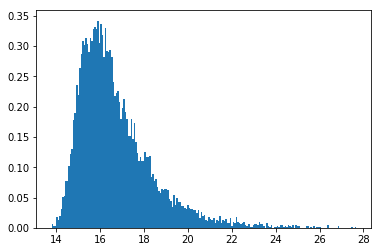

In [158]:
plt.hist(portee_eau,bins = 200, density = True)
plt.show()

# Énergie déposée